# 線形回帰 [勾配降下法による解]

In [41]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
import sklearn.metrics as metrics
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
import torch
import torch.nn as nn
import torch.optim as optim

custom_style = {'axes.labelcolor': 'white',
                'xtick.color': 'white',
                'ytick.color': 'white'}
sns.set_style("darkgrid", rc=custom_style)
plt.style.use('dark_background')

%precision 3
%matplotlib inline

In [42]:
def mse(y, y_):
    return (1/2*(y - y_)**2).mean()

#### データ準備

In [43]:
def getData(a=1.0, b=3.0, N=1000, X_min=0, X_max=20, mu=0, sigma=2):
    e = np.random.normal(0, 2, N)
    X = np.random.normal(10,3,N)
    y = a*X + b + e
    X = X.reshape(-1,1)
#     X2 = np.hstack([np.ones(len(X)).reshape(-1,1),X])
    return X, y

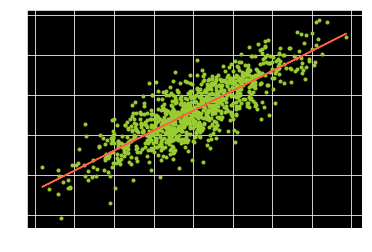

In [44]:
X, y = getData()
plt.scatter(X[:,0], y, marker=".", color="yellowgreen")
plt.plot(X[:,0], 1 * X[:,0] + 3, color="tomato")

#### a, bを総当たり的に当てはめ誤差を描画

In [45]:
def calcCost(x,y, a, b):
    return np.array([np.sqrt(np.mean(1/2*(y - (a2 * x + b2))**2)) for a1, b1 in zip(a,b) for a2, b2 in zip(a1, b1)]).reshape(a.shape)

In [46]:
a = np.linspace(-5, 5, 100)
b = np.linspace(-5,5, 100)
co = np.meshgrid(a,b)
error = calcCost(X,y, co[0], co[1])

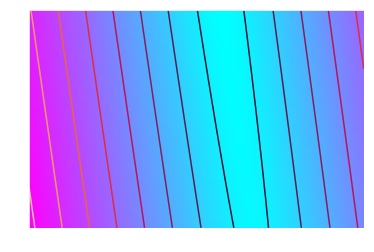

In [47]:
plt.contour(a, b, error)
plt.pcolormesh(a, b, error, cmap = plt.get_cmap('cool'))

#### numpy を使った勾配降下法

In [276]:
def gradientDecentbyNumpy(X, y, epoch=20000, lrs={0:0.01}):
    N = len(y)
    lr = 0.01
    X2 = np.hstack([np.ones(len(X)).reshape(-1,1),X])
    losses = []
    np.random.seed(999)
    w = np.random.randn(2)
    ws = [list(w)]
    for e in range(epoch):
        if e in lrs.keys():
            lr = lrs.get(e)
        y_pred = np.dot(X2, w)
        w -= lr * 1/N * np.dot(X2.T, (y_pred - y))
#         print(lr * 1/N * np.dot(X2.T, (y_pred - y)))
        loss = mse(y, y_pred)
        losses.append(loss)
        ws.append(list(w))
    return np.array(ws), losses, y_pred

#### Pytorchを使った勾配降下法

In [273]:
def gradientDecentbyPytorch(X, y, epoch=20000, lrs={0:0.01} ):
    X2 = np.hstack([np.ones(len(X)).reshape(-1,1),X])
#     wt = torch.randn(2,requireas_grad=True)
    np.random.seed(123)
    wt = torch.from_numpy(np.random.randn(X2.shape[1])).to(dtype=torch.float32)
    wt.requires_grad = True
    xt = torch.Tensor(X2)
    yt = torch.Tensor(y)
    losses = []
    lr = 0.01
    N = len(y)
    wts = [list(wt.data.numpy())]
    for e in range(epoch):
        if e in lrs.keys():
            lr = lrs.get(e)
            
        y_pred = torch.mv(xt, wt)
        error = (y_pred - yt)
        loss = 1/N * torch.sum(1/2 * error**2)
        loss.backward()
        with torch.no_grad():
            wt -= lr * wt.grad
            wt.grad.zero_()
        losses.append(loss.data.numpy())
        wts.append(list(wt.data.numpy()))
        
    return np.array(wts), losses, y_pred.data.numpy()

#### Pytorch + optimizer

In [274]:
def gradientDecentbyPytorchOptim(X, y, epoch=20000, lrs={0:0.01}, isAdam=True):
    X2 = np.hstack([np.ones(len(X)).reshape(-1,1),X])
#     wt = torch.randn(2,requires_grad=True)
    np.random.seed(123)
    wt = torch.from_numpy(np.random.randn(X2.shape[1])).to(dtype=torch.float32)
    wt.requires_grad = True
    xt = torch.Tensor(X2)
    yt = torch.Tensor(y)
    wts =[list(wt.data.numpy())]
    losses = []
    lr = 0.01
    N = len(y)
    criterion = nn.MSELoss()  
    if isAdam:
        optimizer = optim.Adam([wt])
        for e in range(epoch):
            y_pred = torch.mv(xt, wt)
            loss = criterion(y_pred, yt)
            loss.backward()
            optimizer.step()
            losses.append(loss.data.numpy())
            wts.append(list(wt.data.numpy()))
    else:
        optimizer = optim.SGD([wt], lr=lr, momentum=0.0)
        for e in range(epoch):
            wts.append(wt.data.numpy())
            if e in lrs.keys():
                lr = lrs.get(e)
                optimizer = optim.SGD([wt], lr=lr, momentum=0.0)
            y_pred = torch.mv(xt, wt)
#             loss = criterion(y_pred, yt)
            error = (y_pred - yt)
            loss = 1/N * torch.sum(1/2 * error**2)
            loss.backward()
            optimizer.step()
            losses.append(loss.data.numpy())
            wts.append(list(wt.data.numpy()))
            
    return np.array(wts), losses, y_pred.data.numpy()        

#### numpyによる解

In [51]:
def numpyLstsq(X, y):
    X2 = np.hstack([np.ones(len(X)).reshape(-1,1),X])
    w = np.linalg.lstsq(X2,y)[0]
    y_pred = np.dot(X2, w)
    loss = mse(y, y_pred)
    return w, loss, y_pred

#### scikit-learnによる解

In [52]:
def sckitLearn(X, y):   
    clf = LinearRegression()
    clf.fit(X, y)
    w = np.insert(clf.coef_, 0, clf.intercept_)
    y_pred = clf.predict(X)
    loss = mse(y, y_pred)
    return w, loss, y_pred
    

#### 特異値分解を使用した解法

In [53]:
def solutionSVD(X, y):
    X2 = np.hstack([np.ones(len(X)).reshape(-1,1),X])
    U,S,V = np.linalg.svd(X2)
    diag = np.diag(S)
    SSinv = np.zeros(X2.T.shape)
    SSinv[:diag.shape[0], :diag.shape[1]] = np.diag(1/S)
    C = np.dot(np.dot(V.T, SSinv), U.T)
    w = np.dot(C,y)
    y_pred = np.dot(X2, w)
    loss = mse(y, y_pred)
    return w, loss, y_pred

#### 逆行列を使用した解法

In [54]:
def solutionINV(X, y):
    X2 = np.hstack([np.ones(len(X)).reshape(-1,1),X])
    ATAinv = np.linalg.inv(np.dot(X2.T, X2))
    w = np.dot(np.dot(ATAinv, X2.T), y)
    y_pred = np.dot(X2, w)
    loss = mse(y, y_pred)
    return w, loss, y_pred

In [55]:
print(numpyLstsq(X, y)[1])
print(sckitLearn(X, y)[1])
print(solutionSVD(X, y)[1])
print(solutionINV(X, y)[1])

2.1356469287060995
2.1356469287061
2.1356469287060995
2.1356469287060995


/mnt/gold/home/yugi/.local/lib/python3.6/site-packages/ipykernel_launcher.py:3: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  This is separate from the ipykernel package so we can avoid doing imports until


In [56]:
X, y = getData()

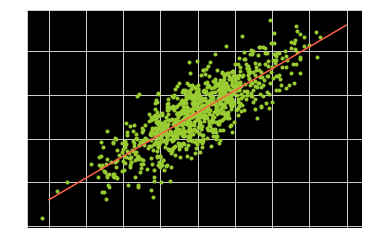

In [57]:
x = np.linspace(0, 20, 100)
plt.scatter(X, y, marker='.', color='yellowgreen')
plt.plot(x, x*1 + 3, color='tomato')

In [58]:
def getPred(X, w):
    return X * w[1] + w[0]

In [189]:
w1, losses1, pred1 = gradientDecentbyNumpy(X, y)
w2, losses2, pred2 = numpyLstsq(X, y)
w3, losses3, pred3 = sckitLearn(X, y)
w4, losses4, pred4 = solutionSVD(X, y)
w5, losses5, pred5 = solutionINV(X, y)

/mnt/gold/home/yugi/.local/lib/python3.6/site-packages/ipykernel_launcher.py:3: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  This is separate from the ipykernel package so we can avoid doing imports until


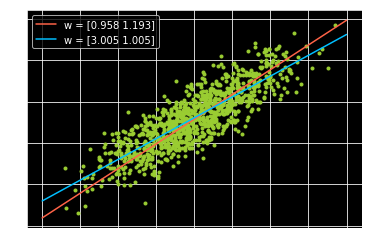

In [191]:
xx = np.linspace(0, 20, 100)
plt.scatter(X, y, marker='.', color='yellowgreen')
plt.plot(xx, getPred(xx, w1), color='tomato', label="w = {}".format(w1))
plt.plot(xx, getPred(xx, w2), color='deepskyblue', label="w = {}".format(w2))
plt.legend()

In [59]:
class myStandardScalar():
    
    def __init_(self):
        self.x_mean_ = np.array([])
        self.y_mean_ = np.array([])
        self.x_std_ = np.array([])
        self.y_std_ = np.array([])
        return self

    def fit_transform(self, x, y):
        self.x_mean_, self.x_std_ = x.mean(), x.std()
        self.y_mean_, self.y_std_ = y.mean(), y.std()
        return (x -  self.x_mean_) /  self.x_std_, (y -  self.y_mean_) /  self.y_std_
    
    def inverse_transform(self, x, y):
        return x * self.x_std_ + self.x_mean_, y * self.y_std_ + self.y_mean_
    
    def inverse_coefficient(self, coeff, intercept):
        co = coeff * self.y_std_ / self.x_std_
        inter = intercept * self.y_std_ - self.y_std_ / self.x_std_ * coeff * self.x_mean_ + self.y_mean_
        return co, inter

In [60]:
sc = myStandardScalar()
X_sc, y_sc = sc.fit_transform(X, y)

In [277]:
lrs = {0: 10**(-4), 30000: 10**(-5), 600000: 10**-6}
w0, losses0, pred0 = solutionSVD(X_sc, y_sc)
w1, losses1, pred1 = gradientDecentbyNumpy(X_sc, y_sc, lrs=lrs, epoch=100000)
w2, losses2, pred2 = gradientDecentbyPytorch(X_sc, y_sc, lrs=lrs, epoch=100000)
w3, losses3, pred3 = gradientDecentbyPytorchOptim(X_sc, y_sc, lrs=lrs, epoch=100000, isAdam=True)
lrs = {0: 10**(-5), 30000: 10**(-6), 600000: 10**-7}
w4, losses4, pred4 = gradientDecentbyPytorchOptim(X_sc, y_sc, lrs=lrs, epoch=100000, isAdam=False)

In [241]:
w1pick = w1[np.argmin(np.array(losses1))]
w2pick = w2[np.argmin(np.array(losses2))]
w3pick = w3[np.argmin(np.array(losses3))]
w4pick = w4[np.argmin(np.array(losses4))]

In [242]:
print(losses0)
print(losses1[-1])
print(losses2[-1])
print(losses3[-1])
print(losses4[-1])

0.16370666604445933
0.16381502034657588
0.16407762
0.58577853
0.2477729


In [244]:
print(w0)
print(w1pick)
print(w2pick)
print(w3pick)
print(w4pick)

[6.679e-17 8.201e-01]
[0.003 0.834]
[-0.026837297 0.8247666]
[-0.0016242821 0.82243115]
[-0.4038737416267395 0.886043906211853]


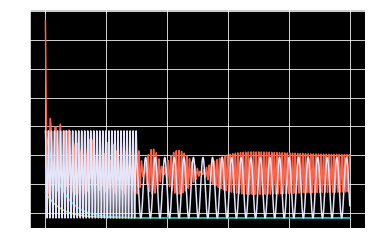

In [245]:
plt.plot(losses1, color="yellowgreen")
plt.plot(losses2, color="deepskyblue")
plt.plot(losses3, color="tomato")
plt.plot(losses4, color="lavender")

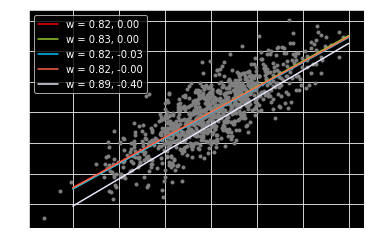

In [254]:
xx = np.linspace(-3, 3, 100)
plt.scatter(X_sc, y_sc, marker='.', color='gray')
plt.plot(xx, getPred(xx, w0), color='red', label="w = {:.2f}, {:.2f}".format(w0[1], w0[0]))
plt.plot(xx, getPred(xx, w1pick), color='yellowgreen', label="w = {:.2f}, {:.2f}".format(w1pick[1], w1pick[0]))
plt.plot(xx, getPred(xx, w2pick), color='deepskyblue', label="w = {:.2f}, {:.2f}".format(w2pick[1], w2pick[0]))
plt.plot(xx, getPred(xx, w3pick), color='tomato', label="w = {:.2f}, {:.2f}".format(w3pick[1], w3pick[0]))
plt.plot(xx, getPred(xx, w4pick), color='lavender', label="w = {:.2f}, {:.2f}".format(w4pick[1], w4pick[0]))
plt.legend()

In [295]:
a = np.linspace(-1.5, 1.5, 100)
b = np.linspace(-1.5,1.5, 100)
co = np.meshgrid(a,b)
# error = calcCost(X_sc,y_sc, co[0], co[1])

In [296]:
def calcCost2(xx, y, a, b):
    error = []
    for a1, b1 in zip(a, b):
        for a2, b2 in zip(a1, b1):
            a2, b2 = np.array([a2]), np.array([b2])
            error.append( ((np.dot(xx, a2) + b2 - y)**2).sum() / len(y) )
    return np.array(error)

In [297]:
error = calcCost2(X_sc, y_sc, co[0], co[1])

In [298]:
print(co[0].flatten()[error.argmin()])
print(co[1].flatten()[error.argmin()])

0.8333333333333335
-0.015151515151515138


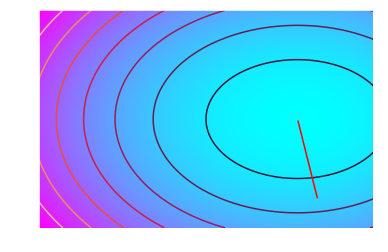

In [299]:
error = error.reshape(co[0].shape)
plt.contour(co[0], co[1], error)
plt.pcolormesh(co[0], co[1], error, cmap = plt.get_cmap('cool'))
plt.plot(w2[:200000,1], w2[:200000,0], color="red")
# plt.plot(w4[:200000,1], w4[:200000,0], color="black")

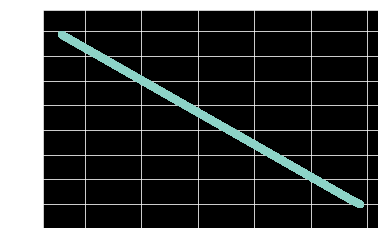

In [260]:
plt.scatter(w2[:,0], w2[:,1])

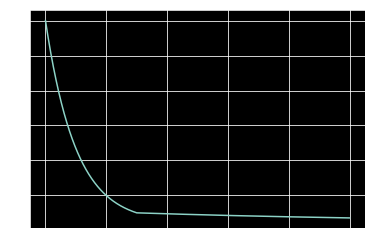

In [261]:
w1 = np.array(w1)
plt.plot(w1[:,1])

#### 正規化前の値に戻して検証

In [289]:
w_inv = sc.inverse_coefficient(w1[-1,1], w1[-1,0])

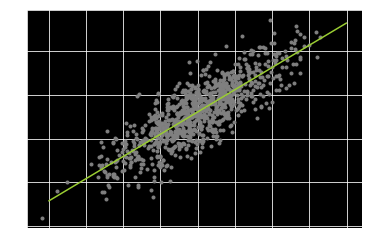

In [294]:
xx = np.linspace(0, 20, 100)
plt.scatter(X, y, marker='.', color='gray')
plt.plot(xx, xx * w_inv[0] + w_inv[1], color="yellowgreen")